# Hasan Touma and Gautham Kovvuru
## Making Legal Chess Moves From Observation

In [194]:
import chess
import chess.svg

from IPython.display import SVG

import pandas as pd
import random
import numpy as np

from keras.datasets import mnist
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Flatten, Lambda, Dense, Activation
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.preprocessing import image    
from matplotlib import pyplot
from scipy.misc import toimage
from keras.optimizers import RMSprop
from sklearn.utils import shuffle
import sklearn.metrics as metrics
import seaborn

### Loading Data:
Our data is from Kaggle and can be downloaded [here][1]. The file contains over 20,000 games with a large variety of information and statistics about each game. For this project we only used the ```moves``` column, but future projects can be enhanced with the other fields in this dataset. There is a sample of the first 5 games in the dataset below.

[1]: https://www.kaggle.com/datasnaek/chess

In [195]:
# Set file name
file_name = 'games.csv'
columns = [
    'id',
    'rated',
    'created_at',
    'last_move_at',
    'turns',
    'victory_status',
    'winner',
    'increment_code',
    'white_id',
    'white_rating',
    'black_id',
    'black_rating',
    'moves',
    'opening_eco',
    'opening_name',
    'opening_ply']

# Read data
df = pd.read_csv(file_name, names = columns, delimiter = ',', header = 0)
df[columns[:-1]] = df[columns[:-1]]
df[columns[-1]] = df[columns[-1]]
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


### Extracting the moves
Since we're only focused on the moves for this project we will collect it in the ```data``` array. Below is a sample of how a game's moves will be represented in our program. As an array of strings.

In [196]:
data = []

(rows, cols) = df.shape
for x in range(0, rows):
    data.append(df.loc[x, 'moves'].split())

print(len(data))
print(data[0], "\n")
print(data[1], "\n")
print(data[2], "\n")
print(data[3], "\n")
print(data[4], "\n")

20058
['d4', 'd5', 'c4', 'c6', 'cxd5', 'e6', 'dxe6', 'fxe6', 'Nf3', 'Bb4+', 'Nc3', 'Ba5', 'Bf4'] 

['d4', 'Nc6', 'e4', 'e5', 'f4', 'f6', 'dxe5', 'fxe5', 'fxe5', 'Nxe5', 'Qd4', 'Nc6', 'Qe5+', 'Nxe5', 'c4', 'Bb4+'] 

['e4', 'e5', 'd3', 'd6', 'Be3', 'c6', 'Be2', 'b5', 'Nd2', 'a5', 'a4', 'c5', 'axb5', 'Nc6', 'bxc6', 'Ra6', 'Nc4', 'a4', 'c3', 'a3', 'Nxa3', 'Rxa3', 'Rxa3', 'c4', 'dxc4', 'd5', 'cxd5', 'Qxd5', 'exd5', 'Be6', 'Ra8+', 'Ke7', 'Bc5+', 'Kf6', 'Bxf8', 'Kg6', 'Bxg7', 'Kxg7', 'dxe6', 'Kh6', 'exf7', 'Nf6', 'Rxh8', 'Nh5', 'Bxh5', 'Kg5', 'Rxh7', 'Kf5', 'Qf3+', 'Ke6', 'Bg4+', 'Kd6', 'Rh6+', 'Kc5', 'Qe3+', 'Kb5', 'c4+', 'Kb4', 'Qc3+', 'Ka4', 'Bd1#'] 

['d4', 'd5', 'Nf3', 'Bf5', 'Nc3', 'Nf6', 'Bf4', 'Ng4', 'e3', 'Nc6', 'Be2', 'Qd7', 'O-O', 'O-O-O', 'Nb5', 'Nb4', 'Rc1', 'Nxa2', 'Ra1', 'Nb4', 'Nxa7+', 'Kb8', 'Nb5', 'Bxc2', 'Bxc7+', 'Kc8', 'Qd2', 'Qc6', 'Na7+', 'Kd7', 'Nxc6', 'bxc6', 'Bxd8', 'Kxd8', 'Qxb4', 'e5', 'Qb8+', 'Ke7', 'dxe5', 'Be4', 'Ra7+', 'Ke6', 'Qe8+', 'Kf5', 'Qxf7+', 'Nf6', 'Nh4+

### Encoding the board and moves
```convertLetterToNumber(letter)``` converts the board pieces into unique arrays with binary values.

In [197]:
def convertLetterToNumber(letter):
    if letter == 'K':
        return [1,0,0,0,0,0,0,0,0,0,0,0]
    if letter == 'Q':
        return [0,1,0,0,0,0,0,0,0,0,0,0]
    if letter == 'R':
        return [0,0,1,0,0,0,0,0,0,0,0,0]
    if letter == 'B':
        return [0,0,0,1,0,0,0,0,0,0,0,0]
    if letter == 'N':
        return [0,0,0,0,1,0,0,0,0,0,0,0]
    if letter == 'P':
        return [0,0,0,0,0,1,0,0,0,0,0,0]
    if letter == 'k':
        return [0,0,0,0,0,0,1,0,0,0,0,0]
    if letter == 'q':
        return [0,0,0,0,0,0,0,1,0,0,0,0]
    if letter == 'r':
        return [0,0,0,0,0,0,0,0,1,0,0,0]
    if letter == 'b':
        return [0,0,0,0,0,0,0,0,0,1,0,0]
    if letter == 'n':
        return [0,0,0,0,0,0,0,0,0,0,1,0]
    if letter == 'p':
        return [0,0,0,0,0,0,0,0,0,0,0,1]
    if letter == '.':
        return [0,0,0,0,0,0,0,0,0,0,0,0]

```move_index(move)``` converts each move to a 64x1 vector that represents the location on the board where the piece is being picked up.

In [198]:
dict = {}
dict['a'] = 0
dict['b'] = 1
dict['c'] = 2
dict['d'] = 3
dict['e'] = 4
dict['f'] = 5
dict['g'] = 6
dict['h'] = 7

In [199]:
def move_index(move):
    arr = np.zeros((8,8))
    arr[8-int(str(move)[1])][dict[str(move)[0]]] = 1
    return arr.flatten()

The goal of the following cell is to take a board, about half way through a game, and encode the location of all the pieces on the board. And also encode the assigned move. Then store those two variables inside ```array_of_games```.

In [223]:
#(0) For each game in data
    #(1) make new board
    #(2) push move to board
    #(3) up to some limit...half way throught the game? Or min moves for all games?
    #(4) encode the board as binary value
    #(5) encode next move as vector

# pick games of length 11
NUM_OF_MOVES = 11

long_enough_games = (game for game in data if len(game) == NUM_OF_MOVES)

w, h = 2, 96;
array_of_games = [[0 for x in range(w)] for y in range(h)] 

# keep track of number of games
num_games = 0
#(0)
for game in long_enough_games:
    #(1) make new board for each game
    board = chess.Board()
    
    #(3) pick random number less than length of game
    stop = NUM_OF_MOVES / 2
    
    # keep track of number of moves...should stop at 10
    
    num_moves = 0
    next_move = ""
    for move in game:
            if num_moves < stop:
                test = board.push_san(move)
                print(test)
                num_moves += 1
            else:
                temp_board = board
                next_move = temp_board.push_san(move)
            # End of "num_moves < stop" if statement
        # End of "game" for loop
    
    print("number of moves: {}\n".format(num_moves))
    
    array_of_games[num_games][0] = [convertLetterToNumber(c) for c in ''.join(str(board).split())]
    print("game number: ", num_games)
    print("next move: ", next_move)
    array_of_games[num_games][1] = move_index(str(next_move))
    num_games += 1
    
# End of "long_enough_games" for loop
print("number of games: ", num_games)

e2e4
c7c5
f1c4
g8f6
d2d3
d7d6
number of moves: 6

game number:  0
next move:  g5f7
e2e4
g8f6
f2f3
e7e5
c2c3
f8e7
number of moves: 6

game number:  1
next move:  d4d5
e2e4
e7e5
g1f3
b8c6
f1b5
g8f6
number of moves: 6

game number:  2
next move:  d4d5
e2e3
e7e5
f1c4
g8e7
d1f3
f7f5
number of moves: 6

game number:  3
next move:  f3f7
d2d4
d7d5
c2c4
c7c6
e2e3
f7f6
number of moves: 6

game number:  4
next move:  b1c3
e2e4
e7e5
f1c4
f8c5
d1f3
f7f6
number of moves: 6

game number:  5
next move:  f3f7
d2d4
d7d5
g1f3
g8f6
c2c3
b8c6
number of moves: 6

game number:  6
next move:  g5f4
e2e4
e7e5
g1f3
g8f6
f3e5
f6e4
number of moves: 6

game number:  7
next move:  f3f7
g1f3
g7g6
g2g3
f8g7
f1g2
d7d6
number of moves: 6

game number:  8
next move:  e2e4
e2e4
e7e5
g1f3
g8f6
f3e5
f6e4
number of moves: 6

game number:  9
next move:  h5f7
g2g4
e7e5
f1g2
d8g5
h2h3
g8f6
number of moves: 6

game number:  10
next move:  e5g4
e2e4
d7d5
e4d5
d8d5
b1c3
d5e5
number of moves: 6

game number:  11
next move:  f3e5
d2

In the following cell we break up the games between a training set and a test set. We decided to have a 2/3 ratio between the training set and the test set. A good future project would be to see how our model holds up against a smaller training set.

In [235]:
X_train = np.zeros((64,64,12))
y_train = np.zeros((64,64))

X_test = np.zeros((32,64,12))
y_test = np.zeros((32,64))

ratio = (2/3)

training_size = int(len(array_of_games) * ratio)
testing_size = len(array_of_games) - training_size
print("Trainig size:", training_size)
print("Testing size:", testing_size)

index = 0
for entry in array_of_games:
    if index < training_size:
        temp1 = np.array(entry[0])
        X_train[index] = temp1
        
        temp2 = np.array(entry[1])
        y_train[index] = temp2
    else:
        temp1 = np.array(entry[0])
        X_test[index-64] = temp1
        
        temp2 = np.array(entry[1])
        y_test[index-64] = temp2
    index += 1

# Shuffle
# X_train, y_train = shuffle(X_train, y_train, random_state=7)

print("index:", index)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Trainig size: 64
Testing size: 32
index: 96
(64, 64, 12)
(64, 64)
(32, 64, 12)
(32, 64)


Our model consists of 2 CNNs, 2 MaxPooling, 2 Dense, and a Flatten layer. The last Dense layer uses the ```softmax``` activation function that outputs a vector of size 64 so our model will give us the location of the piece to move with the highest probability.

In [236]:
model = Sequential()

# BUILD YOUR MODEL HERE (FEEL FREE TO MODIFY THIS CODE)
model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(64,12)))
model.add(Conv1D(64, 2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dense(64, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 63, 64)            1600      
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 62, 64)            8256      
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 31, 64)            0         
_________________________________________________________________
dense_35 (Dense)             (None, 31, 64)            4160      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 15, 64)            0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                61504     
Total para

In [237]:
optimizer = RMSprop()
loss = 'categorical_crossentropy'

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Run the model for 50 epochs

In [238]:
history = model.fit(X_train, y_train, batch_size = 1, epochs=50, verbose=1, validation_split=0.2)

Train on 51 samples, validate on 13 samples
Epoch 1/50
51/51 [==============================] - 1s 24ms/step - loss: 3.8833 - acc: 0.1569 - val_loss: 3.7381 - val_acc: 0.2308
Epoch 2/50
51/51 [==============================] - 0s 5ms/step - loss: 3.0714 - acc: 0.1961 - val_loss: 3.7742 - val_acc: 0.2308
Epoch 3/50
51/51 [==============================] - 0s 5ms/step - loss: 2.8033 - acc: 0.1961 - val_loss: 4.3499 - val_acc: 0.2308
Epoch 4/50
51/51 [==============================] - 0s 6ms/step - loss: 2.5671 - acc: 0.2745 - val_loss: 4.2435 - val_acc: 0.2308
Epoch 5/50
51/51 [==============================] - 0s 6ms/step - loss: 2.2335 - acc: 0.3529 - val_loss: 4.2393 - val_acc: 0.2308
Epoch 6/50
51/51 [==============================] - 0s 6ms/step - loss: 1.8508 - acc: 0.4314 - val_loss: 4.6784 - val_acc: 0.2308
Epoch 7/50
51/51 [==============================] - 0s 5ms/step - loss: 1.3327 - acc: 0.5882 - val_loss: 5.1477 - val_acc: 0.1538
Epoch 8/50
51/51 [===========================

Save the weights to ```model.h5``` and the model to ```model.json```

In [239]:
import json
# Save the weights for grading.
model.save_weights('model.h5', True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

A timelapse of the loss over each epoch.

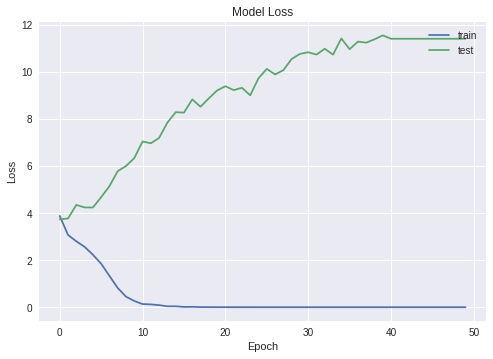

In [240]:
import matplotlib.pyplot as plt
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

The accuracy of the model after 50 epochs

In [241]:
import pandas as pd
score = model.evaluate(X_test, y_test)
print('Test accuracy: ', score[1])

predictions = model.predict_classes(X_test)

predictions = list(predictions)
actuals = list(y_test)

sub = pd.DataFrame({'Actual': actuals, 'Predictions': predictions})
sub.to_csv('./output_cnn.csv', index=False)

32/32 [==============================] - 0s 318us/step
Test accuracy:  0.46875


In [243]:
cm = metrics.confusion_matrix(y_test.argmax(axis=1), model.predict_on_batch(X_test).argmax(axis=1))
cm

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0,

The below confusion matrix shows the correlation between the correct output and the predicted output. We want to see a higher volume of matches along the main diagonal. Even though there are still some ways to improve, the model seems to be able to predict pawns well. This could be because pawns are moved more often in the beginning of a game so there was a larger sample of their movements.

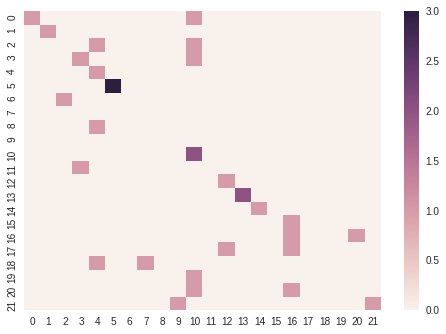

In [244]:
seaborn.heatmap(cm)
plt.show()